Created on Tue Nov  7 16:59:14 2023

@author: Santiago D'hers

Use:

- This script will train AI models to identify exploration using mouse and object position

Requirements:

- The position.csv files processed by 1-Manage_H5.py
- Labeled data for the position files (to train the model)

or

- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [1]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

print(tf.config.list_physical_devices('GPU'))

[]


In [35]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabeled_data.csv')
colabels = pd.read_csv(colabels_file)

before, after = 2, 2 # Say how many frames into the past the models will see
frames = before + after + 1

bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body', 'tail_1', 'tail_2', 'tail_3']
objects = ['obj']

# Set the number of neurons in each layer
param_0 = 64
param_H1 = 32
param_H2 = 16
param_H3 = 8

batch_size = 8 # Set the batch size
lr = 0.0001 # Set the initial learning rate
epochs = 100 # Set the training epochs
patience = 10 # Set the wait for the early stopping mechanism

train_with_average = True # If False, it trains with all the labels separately
make_discrete = False # If False, labels are float (not 0 and 1)

use_saved_data = False # if True, we use the dataframe processed previously

if use_saved_data:
    saved_data = '' # Select the model date you want to rescue

save_data = True # if True, the data processed will be saved with today's date

# Get the start time
start_time = datetime.datetime.now()

In [29]:
def median_filter(df, window_size = 3):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd")
    
    # Apply the median filter
    filtered_df = df.apply(lambda x: x.rolling(window=window_size, center=True).median())
    
    # Fill NaN values with the original values
    filtered_df = filtered_df.combine_first(df)
    
    # Count the number of changed values
    changed_values_count = (df != filtered_df).sum().sum()
    
    # Print the count of changed values
    print(f"Median filter changed {changed_values_count} points")
    
    return filtered_df

def sigmoid(x, k=20):
    return 1 / (1 + np.exp(-k * (x - 0.2) + (k/2)))

In [30]:
def rescale_bodyparts(df, obj, bodyparts):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract obj_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{obj}_x'])
        
        # Subtract obj_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{obj}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]

In [34]:
def reshape(df, back = before, forward = after): # This function reshapes data for LSTM models
    
    reshaped_df = []
    
    for i in range(0, back):
        reshaped_df.append(df[: 1 + back + forward])
            
    for i in range(back, len(df) - forward):
        reshaped_df.append(df[i - back : 1 + i + forward])
    
    for i in range(len(df) - forward, len(df)):
        reshaped_df.append(df[-(1 + back + forward):])
    
    return reshaped_df

In [50]:
# The labels for left and right exploration are on the rest of the columns, we need to extract them
position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy()
                         
lblr_A = colabels.filter(regex='Marian').copy()

lblr_B = colabels.filter(regex='Agus').copy()

lblr_C = colabels.filter(regex='Santi').copy()

lblr_D = colabels.filter(regex='Guille').copy()

lblr_E = colabels.filter(regex='Myself').copy()

geometric = colabels.filter(regex='Geometric').copy() # We dont use the geometric labels to train the model

labelers = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

In [51]:
position

,obj_x,obj_y,nose_x,nose_y,L_ear_x,L_ear_y,R_ear_x,R_ear_y,head_x,head_y,neck_x,neck_y,body_x,body_y
0,10.676213,7.345126,2.024507,23.062414,4.499393,24.614056,4.676455,22.264667,3.707583,23.309061,4.647437,23.382232,6.801261,22.554266
1,10.676213,7.345126,2.032313,23.030572,4.476695,24.602349,4.677881,22.259646,3.706344,23.291517,4.645003,23.374646,6.800826,22.578401
2,10.676213,7.345126,2.049526,22.866338,4.370068,24.545333,4.685789,22.227806,3.699873,23.199195,4.634096,23.332766,6.798868,22.618622
3,10.676213,7.345126,2.071259,22.524379,4.180384,24.423846,4.712145,22.140184,3.686599,23.002754,4.616114,23.230284,6.795610,22.668061
4,10.676213,7.345126,2.097166,22.172864,4.042441,24.264806,4.754650,22.006937,3.675173,22.789827,4.605229,23.082846,6.793597,22.698623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167007,25.660107,7.423698,9.660014,1.888382,8.884265,2.058567,9.742899,2.664604,9.258213,2.152810,9.060616,2.539987,6.717062,4.240516
167008,25.660107,7.423698,9.587492,1.888252,8.860840,2.059297,9.710221,2.661980,9.224973,2.154547,8.926777,2.542458,6.704789,4.250117
167009,25.660107,7.423698,9.472968,1.888038,8.825281,2.059132,9.554994,2.655122,9.169519,2.157334,8.594161,2.538649,6.692142,4.262025
167010,25.660107,7.423698,9.389480,1.887908,8.770371,2.058317,9.168264,2.642714,9.087714,2.159006,8.191759,2.519108,6.677841,4.269160


In [55]:
if train_with_average:
    # Concatenate the dataframes along the columns axis (axis=1) and calculate the mean of each row
    combined_df = pd.concat(labelers, axis=1)
    avrg = pd.DataFrame(combined_df.mean(axis=1), columns=['mean'])
    ready_data = pd.concat([position, avrg], axis = 1)

else:
    # Join position with all the labels separately
    concatenated_position = pd.concat([position] * len(labelers), ignore_index=True)
    concatenated_labelers = pd.concat(labelers, ignore_index=True)
    ready_data = pd.concat([concatenated_position, concatenated_labelers], axis = 1)

print(ready_data.head())

       obj_x     obj_y    nose_x     nose_y   L_ear_x    L_ear_y   R_ear_x  \
0  10.676213  7.345126  2.024507  23.062414  4.499393  24.614056  4.676455   
1  10.676213  7.345126  2.032313  23.030572  4.476695  24.602349  4.677881   
2  10.676213  7.345126  2.049526  22.866338  4.370068  24.545333  4.685789   
3  10.676213  7.345126  2.071259  22.524379  4.180384  24.423846  4.712145   
4  10.676213  7.345126  2.097166  22.172864  4.042441  24.264806  4.754650   

     R_ear_y    head_x     head_y    neck_x     neck_y    body_x     body_y  \
0  22.264667  3.707583  23.309061  4.647437  23.382232  6.801261  22.554266   
1  22.259646  3.706344  23.291517  4.645003  23.374646  6.800826  22.578401   
2  22.227806  3.699873  23.199195  4.634096  23.332766  6.798868  22.618622   
3  22.140184  3.686599  23.002754  4.616114  23.230284  6.795610  22.668061   
4  22.006937  3.675173  22.789827  4.605229  23.082846  6.793597  22.698623   

   mean  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.

In [61]:
def prepare_training_data(df, obj = 'obj', bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body'], y_col = 'mean'):
    
    # Group the DataFrame by the values in the first column
    groups = df.groupby(df[f'{obj}_x'])
    
    # Split the DataFrame into multiple DataFrames and labels
    final_dataframes = {}
    wide_dataframes = {}
    
    for category, group in groups:

        rescaled_data = rescale_bodyparts(group, obj, bodyparts)
        labels = group[f'{y_col}']

        final_dataframes[category] = {'position': rescaled_data, 'labels': labels}
        reshaped_data = reshape(rescaled_data)
        wide_dataframes[category] = {'position': reshaped_data, 'labels': labels}
        
    # Get a list of the keys (categories)
    keys = list(wide_dataframes.keys())
    
    # Shuffle the keys
    np.random.shuffle(keys)
    
    # Calculate the lengths for each part
    len_val = len(keys) * 15 // 100
    len_test = len(keys) * 15 // 100
    
    # Use slicing to divide the list
    val_keys = keys[:len_val]
    test_keys = keys[len_val:(len_val + len_test)]
    train_keys = keys[(len_val + len_test):]
    
    # Initialize empty lists to collect dataframes
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    X_val = []
    y_val = []
    
    # first the simple data 
    for key in train_keys:
        X_train.append(final_dataframes[key]['position'])
        y_train.append(final_dataframes[key]['labels'])
    for key in test_keys:
        X_test.append(final_dataframes[key]['position'])
        y_test.append(final_dataframes[key]['labels'])
    for key in val_keys:
        X_val.append(final_dataframes[key]['position'])
        y_val.append(final_dataframes[key]['labels'])
    
    X_train = pd.concat(X_train, ignore_index=True)
    X_test = pd.concat(X_test, ignore_index=True)
    X_val = pd.concat(X_val, ignore_index=True)
        
    y_train = pd.concat(y_train, ignore_index=True)
    y_test = pd.concat(y_test, ignore_index=True)
    y_val = pd.concat(y_val, ignore_index=True)
    
    # Now for the wide data
    X_train_wide = []
    X_test_wide = []
    X_val_wide = []
     
    for key in train_keys:
        X_train_wide.extend(wide_dataframes[key]['position'])
    for key in test_keys:
        X_test_wide.extend(wide_dataframes[key]['position'])
    for key in val_keys:
        X_val_wide.extend(wide_dataframes[key]['position'])

    return X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val

In [62]:
if use_saved_data:
    # Load arrays
    with h5py.File(saved_data, 'r') as hf:
        X_test = hf['X_test'][:]
        y_test = hf['y_test'][:]
        X_val = hf['X_val'][:]
        y_val = hf['y_val'][:]
        X_train = hf['X_train'][:]
        y_train = hf['y_train'][:]
        X_test_wide = hf['X_test_wide'][:]
        X_val_wide = hf['X_val_wide'][:]
        X_train_wide = hf['X_train_wide'][:]
        
    print("Data is ready to train")

else:
    X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val = prepare_training_data(ready_data)
    
    # Print the sizes of each set
    print(f"Training set size: {len(X_train)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Testing set size: {len(X_test)} samples")
    print(f"Total samples: {len(X_train)+len(X_val)+len(X_test)}")

    if save_data:
        # Save arrays
        with h5py.File(os.path.join(STORM_folder, f'training_data/training_data_{start_time.date()}.h5'), 'w') as hf:
            hf.create_dataset('X_test', data=X_test)
            hf.create_dataset('y_test', data=y_test)
            hf.create_dataset('X_val', data=X_val)
            hf.create_dataset('y_val', data=y_val)
            hf.create_dataset('X_train', data=X_train)
            hf.create_dataset('y_train', data=y_train)
            hf.create_dataset('X_test_wide', data=X_test_wide)
            hf.create_dataset('X_val_wide', data=X_val_wide)
            hf.create_dataset('X_train_wide', data=X_train_wide)
            
            print(f'Saved data to training_data_{start_time.date()}.h5')

Training set size: 118169 samples
Validation set size: 23839 samples
Testing set size: 25004 samples
Total samples: 167012
Saved data to training_data_2024-10-14.h5


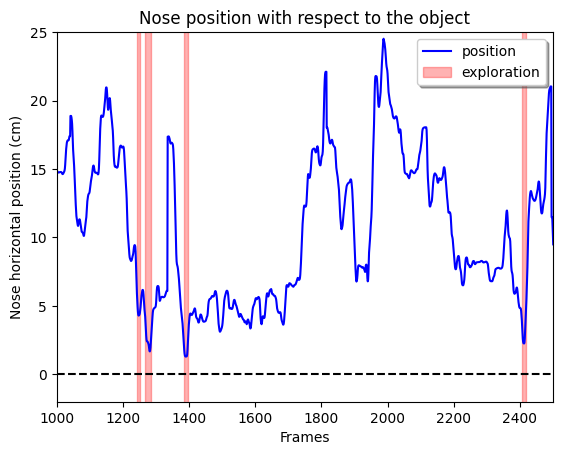

In [79]:
# Select data to plot
position = np.sqrt(X_test['nose_x']**2 + X_test['nose_y']**2).copy()
exploration = y_test.copy()

# Plotting position
plt.plot(position, label='position', color='blue')

# Shading exploration regions
plt.fill_between(range(len(exploration)), -30, 30, where = exploration > 0, label = 'exploration', color='red', alpha=0.3)

# Adding labels
plt.xlabel('Frames')
plt.ylabel('Nose horizontal position (cm)')
plt.legend(loc='upper right', fancybox=True, shadow=True, framealpha=1.0)
plt.title('Nose position with respect to the object')
plt.axhline(y=0, color='black', linestyle='--')

# Zoom in on some frames
plt.xlim((1000, 2500))
plt.ylim((-2, 25))

plt.show()

Lets get some tools ready for model training:

- Early stopping
- Scheduled learning rate

In [80]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    mode='min',
    verbose=1,
)

# Define a learning rate schedule function
initial_lr = lr # Set the initial lr
def lr_schedule(epoch, lr): # Define a learning rate schedule function
    initial_lr = lr  # Initial learning rate
    decay_factor = 0.9  # Learning rate decay factor
    decay_epochs = 9    # Number of epochs after which to decay the learning rate

    # Calculate the new learning rate
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))

    return lr

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [81]:
def plot_history(model, model_name):
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(model.history['loss'], label='Training loss')
    plt.plot(model.history['val_loss'], label='Validation loss')
    plt.plot(model.history['accuracy'], label='Training accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation accuracy')
    
    plt.title(f'Training of model {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.legend()
    plt.show()

In [82]:
def evaluate(X, y, model):
    
    # Evaluate the model on the testing set
    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    y_binary = (y > 0.5).astype(int) # Convert average labels to binary labels
    
    accuracy = accuracy_score(y_binary, y_pred_binary)
    precision = precision_score(y_binary, y_pred_binary, average = 'weighted')
    recall = recall_score(y_binary, y_pred_binary, average = 'weighted')
    f1 = f1_score(y_binary, y_pred_binary, average = 'weighted')
    
    print(classification_report(y_binary, y_pred_binary))
    
    return accuracy, precision, recall, f1

def evaluate_continuous(X, y, model):
    # Ensure X and y are on the same device
    if isinstance(X, tf.Tensor):
        if '/GPU:' in X.device:
            y = tf.convert_to_tensor(y)
            y = tf.identity(y)

    # Evaluate the model on the testing set
    y_pred = model.predict(X)

    # Convert y and y_pred to numpy arrays if they are tensors
    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return mse, mae, r2

Now we train the first model

In [83]:
# Build a simple neural network
model_simple = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(param_0, activation='relu'),
    Dropout(0.2),
    Dense(param_H1, activation='relu'),
    Dropout(0.2),
    Dense(param_H2, activation='relu'),
    Dropout(0.2),
    Dense(param_H3, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
model_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history_simple = model_simple.fit(X_train, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.8902 - loss: 0.1820 - val_accuracy: 0.9166 - val_loss: 0.1001 - learning_rate: 1.0000e-04
Epoch 2/100
 7265/14772 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9174 - loss: 0.1165

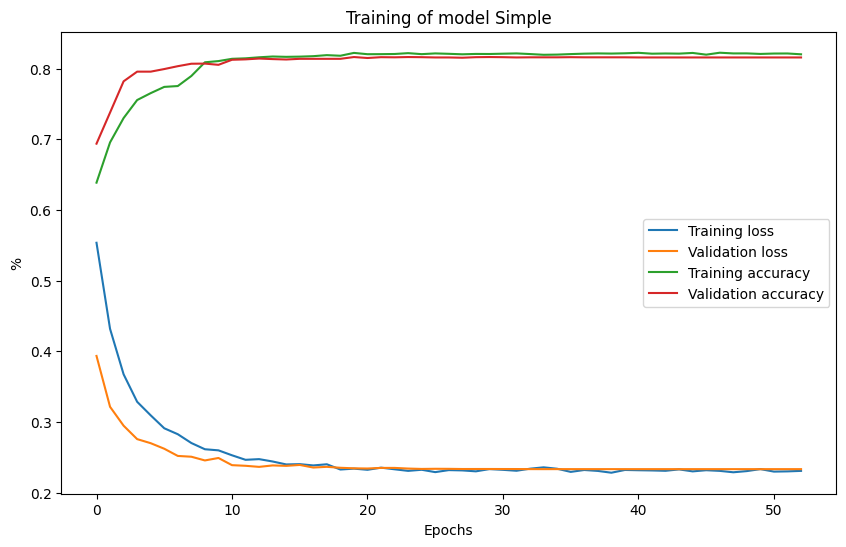

In [27]:
# Plot the training and validation loss
plot_history(history_simple, "Simple")

In [28]:
# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple = evaluate(X_test, y_test, model_simple)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")

mse_simple, mae_simple, r2_simple = evaluate_continuous(X_test, y_test, model_simple)
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      3723
           1       0.72      0.95      0.81      1132

    accuracy                           0.90      4855
   macro avg       0.85      0.92      0.87      4855
weighted avg       0.92      0.90      0.90      4855

Accuracy = 0.8997, Precision = 0.9196, Recall = 0.8997, F1 Score = 0.9041 -> simple
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
MSE = 0.0642, MAE = 0.1282, R-squared = 0.6081 -> simple


In [29]:
# Save the model
model_simple.save(os.path.join(STORM_folder, f'simple/model_simple_{start_time.date()}.keras'))

Lets move onto training a Recursive Network (that can see sequences)

In [30]:
X_train_seq = np.array([df.values for df in X_train_wide])
X_val_seq = np.array([df.values for df in X_val_wide])
X_test_seq = np.array([df.values for df in X_test_wide])

In [31]:
# Define the LSTM model
model_wide = tf.keras.Sequential([
    Input(shape=(frames, X_train_seq.shape[2])),
    LSTM(param_0, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H1, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H2, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H3),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_wide.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model_wide.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,073 (140.91 KB)

 Trainable params: 36,073 (140.91 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model
history_wide = model_wide.fit(X_train_seq, y_train,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_seq, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
2915/2915 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7172 - loss: 0.4524 - val_accuracy: 0.8036 - val_loss: 0.2747 - learning_rate: 1.0000e-04
Epoch 2/100
2915/2915 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8086 - loss: 0.2595 - val_accuracy: 0.8140 - val_loss: 0.2596 - learning_rate: 1.0000e-04
Epoch 3/100
2915/2915 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8100 - loss: 0.2469 - val_accuracy: 0.8104 - val_loss: 0.2603 - learning_rate: 1.0000e-04
Epoch 4/100
2915/2915 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8167 - loss: 0.2371 - val_accuracy: 0.8136 - val_loss: 0.2539 - learning_rate: 1.0000e-04
Epoch 5/100
2915/2915 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8210 - loss: 0.2215 - val_accuracy: 0.8084 - val_loss: 0.2565 - learning_rate: 1.0000e-04
Epoch 6/100
2915/2915 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8260 - loss: 0.2120 - val_accuracy: 0.8158 - val_loss: 0.2388 - learning_rate: 1.0000e-04
Epoch 7/100
2915/2915 ━━━━━━━━━━━━━━━━━━

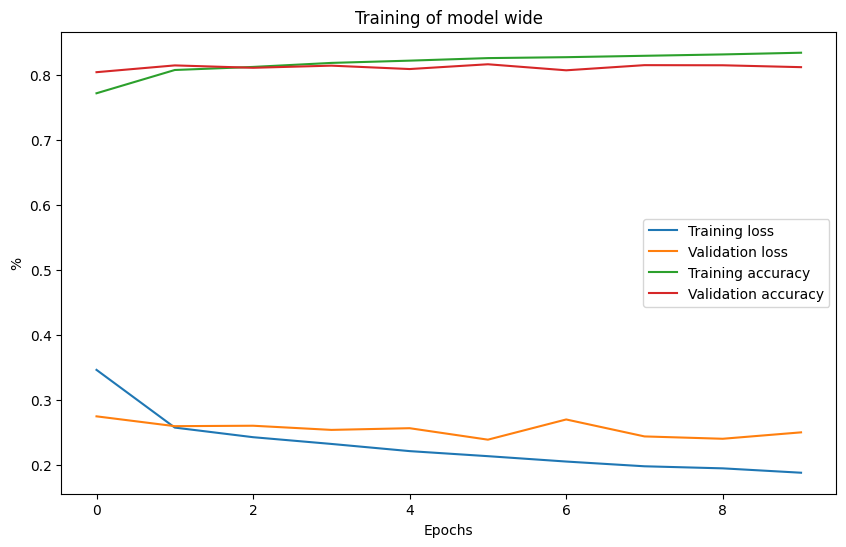

In [34]:
# Plot the training and validation loss
plot_history(history_wide, "wide")

In [35]:
# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide = evaluate(X_test_seq, y_test, model_wide)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")

mse_wide, mae_wide, r2_wide = evaluate_continuous(X_test_seq, y_test, model_wide)
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      3723
           1       0.61      0.88      0.72      1132

    accuracy                           0.84      4855
   macro avg       0.79      0.86      0.81      4855
weighted avg       0.88      0.84      0.85      4855

Accuracy = 0.8430, Precision = 0.8787, Recall = 0.8430, F1 Score = 0.8516 -> wide
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE = 0.0859, MAE = 0.1829, R-squared = 0.4752 -> wide


In [36]:
# Save the model
model_wide.save(os.path.join(STORM_folder, f'wide/model_wide_{start_time.date()}.keras'))

Lets also train a Random Forest model

In [37]:
# We train a RF model with the same data
if not make_discrete:
    y_train = (y_train > 0.5).astype(int)

# Create the Random Forest model (and set the number of estimators (decision trees))
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier with your data
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [38]:
# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF = evaluate(X_test, y_test, RF_model)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

mse_RF, mae_RF, r2_RF = evaluate_continuous(X_test, y_test, RF_model)
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      3723
           1       0.67      0.91      0.77      1132

    accuracy                           0.88      4855
   macro avg       0.82      0.89      0.84      4855
weighted avg       0.90      0.88      0.88      4855

Accuracy = 0.8758, Precision = 0.9010, Recall = 0.8758, F1 Score = 0.8817 -> RF
MSE = 0.1165, MAE = 0.1307, R-squared = 0.2886 -> RF


In [39]:
# Save the model
joblib.dump(RF_model, os.path.join(STORM_folder, f'RF/model_RF_{start_time.date()}.pkl'))

['C:/Users/dhers/Desktop\\STORM/models\\RF/model_RF_2024-10-13.pkl']

In [40]:
# Get the end time
end_time = datetime.datetime.now()

# Calculate elapsed time
elapsed_time = end_time - start_time

In [41]:
# Print the model results
print(f"Script execution time: {elapsed_time}).")

print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

Script execution time: 0:19:49.670321).
Evaluate model vs testing data
VS binary average
Accuracy = 0.8997, Precision = 0.9196, Recall = 0.8997, F1 Score = 0.9041 -> simple
Accuracy = 0.8430, Precision = 0.8787, Recall = 0.8430, F1 Score = 0.8516 -> wide
Accuracy = 0.8758, Precision = 0.9010, Recall = 0.8758, F1 Score = 0.8817 -> RF
VS continuous average
MSE = 0.0642, MAE = 0.1282, R-squared = 0.6081 -> simple
MSE = 0.0859, MAE = 0.1829, R-squared = 0.4752 -> wide
MSE = 0.1165, MAE = 0.1307, R-squared = 0.2886 -> RF


In [42]:
# Lets test the accuracy of a random and zero y_test

y_zeros = y_test - y_test

y_random = y_test.sample(frac=1).reset_index(drop=True)
y_random_binary = (y_random > 0.5).astype(int)

y_binary = (y_test > 0.5).astype(int)

In [43]:
# zeros
print(classification_report(y_binary, y_zeros))

accuracy_zeros = accuracy_score(y_binary, y_zeros)
precision_zeros = precision_score(y_binary, y_zeros, average = 'weighted')
recall_zeros = recall_score(y_binary, y_zeros, average = 'weighted')
f1_zeros = f1_score(y_binary, y_zeros, average = 'weighted')
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")

mse_zeros = mean_squared_error(y_test, y_zeros)
mae_zeros = mean_absolute_error(y_test, y_zeros)
r2_zeros = r2_score(y_test, y_zeros)
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3723
           1       0.00      0.00      0.00      1132

    accuracy                           0.77      4855
   macro avg       0.38      0.50      0.43      4855
weighted avg       0.59      0.77      0.67      4855

Accuracy = 0.7668, Precision = 0.5880, Recall = 0.7668, F1 Score = 0.6656 -> zeros
MSE = 0.2174, MAE = 0.2316, R-squared = -0.3277 -> zeros


c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

In [44]:
# random
print(classification_report(y_binary, y_random_binary))

accuracy_random = accuracy_score(y_binary, y_random_binary)
precision_random = precision_score(y_binary, y_random_binary, average = 'weighted')
recall_random = recall_score(y_binary, y_random_binary, average = 'weighted')
f1_random = f1_score(y_binary, y_random_binary, average = 'weighted')
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

mse_random = mean_squared_error(y_test, y_random)
mae_random = mean_absolute_error(y_test, y_random)
r2_random = r2_score(y_test, y_random)
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      3723
           1       0.21      0.21      0.21      1132

    accuracy                           0.63      4855
   macro avg       0.48      0.48      0.48      4855
weighted avg       0.63      0.63      0.63      4855

Accuracy = 0.6305, Precision = 0.6305, Recall = 0.6305, F1 Score = 0.6305 -> random
MSE = 0.3385, MAE = 0.3644, R-squared = -1.0680 -> random


In [45]:
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

Evaluate model vs testing data
VS binary average
Accuracy = 0.8997, Precision = 0.9196, Recall = 0.8997, F1 Score = 0.9041 -> simple
Accuracy = 0.8430, Precision = 0.8787, Recall = 0.8430, F1 Score = 0.8516 -> wide
Accuracy = 0.8758, Precision = 0.9010, Recall = 0.8758, F1 Score = 0.8817 -> RF
Accuracy = 0.7668, Precision = 0.5880, Recall = 0.7668, F1 Score = 0.6656 -> zeros
Accuracy = 0.6305, Precision = 0.6305, Recall = 0.6305, F1 Score = 0.6305 -> random
VS continuous average
MSE = 0.0642, MAE = 0.1282, R-squared = 0.6081 -> simple
MSE = 0.0859, MAE = 0.1829, R-squared = 0.4752 -> wide
MSE = 0.1165, MAE = 0.1307, R-squared = 0.2886 -> RF
MSE = 0.2174, MAE = 0.2316, R-squared = -0.3277 -> zeros
MSE = 0.3385, MAE = 0.3644, R-squared = -1.0680 -> random
